<a href="https://colab.research.google.com/github/benihime91/midas-summer-internship-2021/blob/main/midas_task_2_part_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# > Uncomment and run this cell if running on Google Colab
# install required dependencies for google colab
!git clone https://github.com/benihime91/midas-summer-internship-2021.git
!pip install --upgrade -r "/content/midas-summer-internship-2021/requirements.txt"

In [1]:
# > for Goggle Colab
import sys
sys.path.append("midas-summer-internship-2021/")

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

# Task 2

## Part - 1
> Use this dataset (https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip) to train a CNN. Use no other data source or pretrained networks, and explain your design choices during preprocessing, model building and training. Also, cite the sources you used to borrow techniques. A test set will be provided later to judge the performance of your classifier. Please save your model checkpoints.

### Getting the Data

In [ ]:
import os
os.makedirs("data", exist_ok=True)

# Download the 1st Dataset using :
!wget -P "data/" https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip
!unzip --qq "data/trainPart1.zip" -d "data/"

### Analyzing the Dataset
> In this part we will analyze the get familiar with the given dataset.

In [4]:
# imports
import os
import random
from typing import *

import matplotlib.pyplot as plt
import pandas as pd
from fastcore.all import *
from torchvision.datasets.folder import IMG_EXTENSIONS

pd.set_option("display.max_colwidth", None)

In [5]:
DATASET_01_PATH = Path("data/train/")
DATASET_01_PATH.ls()

(#62) [Path('data/train/Sample033'),Path('data/train/Sample025'),Path('data/train/Sample053'),Path('data/train/Sample026'),Path('data/train/Sample050'),Path('data/train/Sample044'),Path('data/train/Sample035'),Path('data/train/Sample060'),Path('data/train/Sample024'),Path('data/train/Sample020')...]

Perform some one-off data manipulations to get all the files and filenames in an easy to use format

In [6]:
def folder2df(directory: Union[str, Path], extensions: list = IMG_EXTENSIONS,
              shuffle: bool = False, seed: int = 42):
    """
    Parses all the Images in `directory` and puts them in a `DataFrame` object.
    """

    random.seed(seed)

    image_list = L()
    target_list = L()

    if not isinstance(directory, Path):
        directory = Path(directory)

    for label in directory.ls():
        label = Path(label)
        if os.path.isdir(label):
            for img in label.ls():
                if str(img).lower().endswith(extensions):
                    image_list.append(img)
                    target_list.append(str(label).split(os.path.sep)[-1])

    print(f"Found {len(image_list)} files belonging to {len(set(target_list))} classes.")

    dataframe: pd.DataFrame = pd.DataFrame()
    dataframe["image_id"] = image_list.map(str)
    dataframe["target"] = target_list
    if shuffle:
        dataframe = (dataframe.sample(frac=1, random_state=seed)
                     .reset_index(inplace=False, drop=True))
    return dataframe

Create the a `pandas Dataframe` which contains all the file info we need to get started

In [7]:
DATASET_01 = folder2df(directory=DATASET_01_PATH, shuffle=True)
DATASET_01.head()

Found 2480 files belonging to 62 classes.


,image_id,target
0,data/train/Sample004/img004-001.png,Sample004
1,data/train/Sample035/img035-004.png,Sample035
2,data/train/Sample043/img043-008.png,Sample043
3,data/train/Sample046/img046-005.png,Sample046
4,data/train/Sample025/img025-050.png,Sample025


Lets look closer at the data, how many `class_ids` do we have?

In [8]:
unq_cls = DATASET_01.target.unique()
tot_itm = len(DATASET_01)
print("Total number of Images in the Dataset: ", tot_itm)
print("Number of unique classes in the Dataset: ",len(unq_cls))

Total number of Images in the Dataset:  2480
Number of unique classes in the Dataset:  62


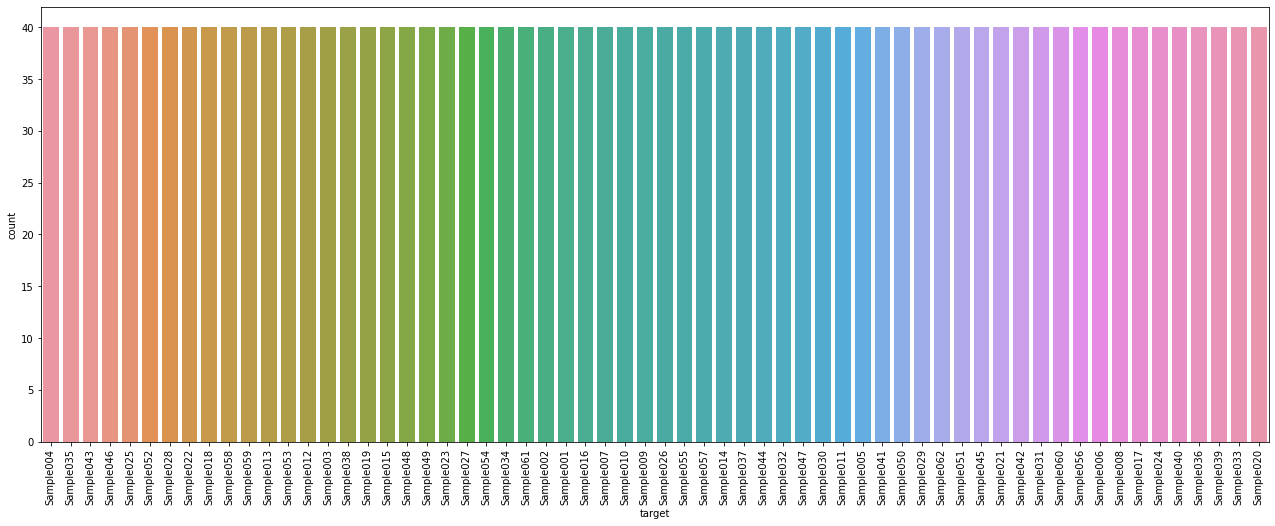

In [9]:
import seaborn as sns

_, ax = plt.subplots(1, 1, figsize=(22, 8))
sns.countplot(data=DATASET_01, x="target", ax=ax);
plt.xticks(rotation=90);

The distibution across all the classes is exactly same. This is a good thing because in this way our model will be less prone to overfitting for a prticular class. We have around 40 Images for each class, which is way less data than I would have preferred. We might overfit the training data due to lack of data.

### Data Loading

Since, in this task in am going to be using `PyTorch`, before we can directly start training the `CNN network`, we need to get our data into `Dataset` and `DataLoader`.

In [10]:
import albumentations as A
import cv2
import torchvision.transforms as T
from albumentations.pytorch import ToTensorV2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

We also need to encode our string labels into interger labels. For this we will use the `LabelEncoder()` from scikit-learn.

In [11]:
encoder = LabelEncoder()
encoder.fit(unq_cls)

def encode_label(x):
    "Encoder `x`, given x is a scalar value"
    return encoder.transform([x]).item()

CLASS_MAP = L(list(encoder.classes_)).map_dict(encode_label)
CLASS_MAP = {k:v for v, k in CLASS_MAP.items()}

DATASET_01["cat_label"] = DATASET_01["target"].map(encode_label)
DATASET_01.head()

,image_id,target,cat_label
0,data/train/Sample004/img004-001.png,Sample004,3
1,data/train/Sample035/img035-004.png,Sample035,34
2,data/train/Sample043/img043-008.png,Sample043,42
3,data/train/Sample046/img046-005.png,Sample046,45
4,data/train/Sample025/img025-050.png,Sample025,24


Save a copy of the `CLASS_MAP` which stores the mapping of `classes` and `class ids`

In [12]:
import json

with open("data/class_map_ds01.json", 'w') as f:
    json.dump(CLASS_MAP, f)

Let's also create a Training and Validation split on the data.

Why we need a different training and validation split for the data ?

This is so that we don't inadvertently overfit, train a model to work well only on our training data. For this purpose we will compute metric over on the validation data. During the training phase the model will see only the training data. The Validation data will remain separate and will only be used for calculation of the *metric*. 

In [13]:
TRAIN_DATASET_01, VALID_DATASET_01 = train_test_split(DATASET_01, test_size=0.2, random_state=42, 
                                                      shuffle=True, stratify=DATASET_01['cat_label'])

TRAIN_DATASET_01 = TRAIN_DATASET_01.reset_index(drop=True, inplace=False)
VALID_DATASET_01 = VALID_DATASET_01.reset_index(drop=True, inplace=False) 

print("Num Training Examples: ", len(TRAIN_DATASET_01))
print("Num Validation Examples: ", len(VALID_DATASET_01))

Num Training Examples:  1984
Num Validation Examples:  496


Now we will create a custom `Dataset` obj that can parse the data.

In [14]:
class PandasDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transforms):
        self._dataframe  = df
        self._transforms = transforms
        self._gray_scale = T.Grayscale(num_output_channels=3)
    
    @property
    def transforms(self):
        return self._transforms
        
    def __len__(self):
        return len(self._dataframe)
    
    def __getitem__(self, idx):
        im = self._dataframe['image_id'][idx]
        
        # Load and apply transformations to the Image
        im = cv2.imread(im)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = self._transforms(image=im)["image"]

        # convert the Images to grayscale Images with 3 dimensions
        im = self._gray_scale(im)
        
        lbl = self._dataframe["cat_label"][idx]   
        return im, lbl

Lets define what we want our transforms to be -

We'll use the presize the images 160 px make things faster still, and will center crop to 128 px.
Initially I will not be using any other fancy data augmentations. After the resizing I will normalize the Images by dividing by 255.0 and also converting them to pytorch tensors.

In [15]:
PRESIZE  = 80
IMG_SIZE = 64

base_tfms = A.Compose([
    A.Resize(PRESIZE, PRESIZE, p=1.0),
    A.CenterCrop(IMG_SIZE, IMG_SIZE, p=1.0),
    A.ToFloat(max_value=255, p=1.0),
    ToTensorV2(p=1.0),
])

Function to get our data -

In [16]:
def get_data(transforms = base_tfms, valid_transforms=base_tfms, bs: int = 32):
    # instantiate the dataset set obj
    train_ds = PandasDataset(df=TRAIN_DATASET_01, transforms=transforms)
    valid_ds = PandasDataset(df=VALID_DATASET_01, transforms=valid_transforms)

    # create the dataloaders obj
    train_dl = DataLoader(train_ds, batch_size=bs, num_workers=num_cpus(), shuffle=True) 
    valid_dl = DataLoader(valid_ds, batch_size=bs, num_workers=num_cpus(), shuffle=False)
    return train_dl, valid_dl

Having a look at the images in our `DataLoader` you can see result of the image transforms:

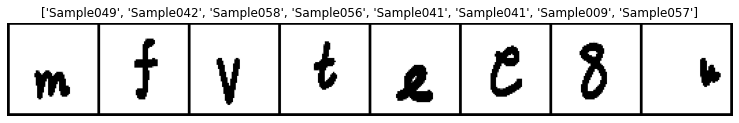

In [17]:
train_dl, valid_dl = get_data(transforms=base_tfms, valid_transforms=base_tfms)

ims, lbls = next(iter(train_dl))
ims, lbls = ims[:8], lbls[:8]

grid = make_grid(ims, normalize=True).permute(1, 2, 0)
fig = plt.figure(figsize=(13, 13))
plt.imshow(grid) 
plt.title([CLASS_MAP[o] for o in lbls.data.cpu().numpy()])
plt.axis("off");

del train_dl, valid_dl

### PyTorch Lightning Task -
For training I will be using PyTorch Lightning ⚡️. PyTorch Lightning expects the whole training pipeline to be defined under a `LightningModule`. Let's convert our model in a `LightningModule`.

For evaluating the model initially I will use the `Accuracy` metric and for loss function i will use the standart `nn.CrossEntropyLoss()` from PyTorch.


The code block below create a general PyTorch Lightning Classification Task which helps us iterate different models inside a `LightningModule.`

In [18]:
import gc
import math
from collections import OrderedDict

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from IPython.display import Markdown, display
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.metrics import functional as FM
from torch import nn, optim
from torch.nn.utils import spectral_norm

from progress import NotebookProgressCallback

pl.seed_everything(42)

Global seed set to 42


42

In [19]:
class ClassificationTask(pl.LightningModule):
    def __init__(self, model: nn.Module, lr: float, wd: float = 0, criterion: nn.Module = nn.CrossEntropyLoss()):
        super().__init__()
        self.save_hyperparameters("lr", "wd")
        self.model = model
        self.criterion = criterion
        
    def forward(self, xb):
        "Same as nn.Module forward"
        return self.model(xb)
    
    def training_step(self, batch, batch_idx):
         x, y = batch
         y_hat = self.model(x)
         loss = self.criterion(y_hat, y)
         self.log("train_loss", loss)
         return loss

    def validation_step(self, batch, batch_idx, *args, **kwargs):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        acc = FM.accuracy(F.softmax(y_hat), y)
        metrics = {'val_acc': acc, 'val_loss': loss}
        self.log_dict(metrics)
        return metrics

    def test_step(self, batch, batch_idx, *args, **kwargs):
        metrics = self.validation_step(batch, batch_idx, *args, **kwargs)
        metrics = {'test_acc': metrics['val_acc'], 'test_loss': metrics['val_loss']}
        self.log_dict(metrics)
        
    def configure_optimizers(self):
        """
        define optimizers and LR schedulers for use in training.
        """
        # default Adam parameters from fast.ai
        opt   = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.wd, betas=(0.9, 0.99), eps=1e-05)
        steps = len(self.train_dataloader())
        epochs= self.trainer.max_epochs
        
        scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=self.hparams.lr, epochs=epochs, steps_per_epoch=steps)
        return [opt], [dict(scheduler=scheduler, interval='step')]

For training I will be using the popular `AdamW + 1cycle` training approach. Here we use the `AdamW` optimizer and `OneCycleLR` scheduler from PyTorch.

`AdamW` was inroduced in this [paper](https://arxiv.org/abs/1711.05101). Experiments by the fast.ai group has shown that `AdamW` along with the `1cycle policy` of learning rate scheduling gives very good results. `AdamW` differs from `Adam` is the sense that AdamW uses true weight decay (decay the weights directly) while Adam uses L2 regularization (add the decay to the gradients).

The `1cycle policy` was introduced by Leslie N. Smith et al. in [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120).


`AdamW + 1cycle` was incremental in fast.ai winning the `DAWNBench` competition.

### Benchmark Model
First I will let's start by making a good baseline Model and subsequently we will experiment by improving upon this model.

Let's first create the building blocks that we will use building our network.

In [20]:
class ConvBnDropBlock(nn.Sequential):
    "Create sequence of convolutional, Activation, `BatchNorm` & Drouput layers."
    def __init__(self, in_chans, out_chans, kernel_size, stride=1, dilation=1, 
                 padding = None, bias=True, act_cls: Callable = nn.ReLU, 
                 p_drop=0.0, use_bn=True,):

        if padding is None: 
            padding = (kernel_size-1)//2
        
        layers = []
        
        conv_layer = nn.Conv2d(in_chans, out_chans, kernel_size, stride, 
                               dilation=dilation, padding=padding, bias=bias)
        
        if act_cls is not None:
            act_layer = act_cls(inplace=True)
        else:
            act_layer = nn.Identity()
        if use_bn:
            norm_layer = nn.BatchNorm2d(out_chans)
        else:
            norm_layer = nn.Identity()
           
        layers += [conv_layer, act_layer, norm_layer]
        
        if p_drop > 0.0:
            layers.append(nn.Dropout2d(p=p_drop))
            
        super(ConvBnDropBlock, self).__init__(*layers)

For this whole experiment my models will be divided into 2 parts a `feature_extractor` and `classifier`. The feature extractor is responsible for generating the feature maps from the Images, while the `classifier` is responsible for final classification.

A baseline model will establish a minimum model performance to which all of our other models can be compared, as well as a model architecture that we can use as the basis of study and improvement.

A feature extractor of baseline model architecture has been partly inspired from the general architectural principles of the `VGG models` & from this [blog post](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/).

The architecture involves stacking convolutional layers with small `3×3` filters followed by a activation, batchnorm, dropout.Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128. The first 2 blocks are followed by a max_pool layer while the 3rd layer is follwed by a `pool_flatten` layer i.e., a combination of  AdaptiveAvgPool2d and flatten layer from pytorch.

We use a AdaptiveAvgPool layer so that our network is *fully convolutional* and so can work for any image size that is to say that a model trainined on 64x64 images will also work for 120x120 images.

This completes the feature extractor part of the model. For the classifier of the model: first, the feature maps output from the feature extraction part of the model must be flattened.
We than use a Dropuout layer followed by a Linear layer to generate the predictions.

Let's create the network architecture -

In [21]:
class BenchmarkModel(nn.Sequential):
    def __init__(self, num_outputs: int):
        conv_block_01 = ConvBnDropBlock(in_chans=3, out_chans=32, bias=False, 
                                        use_bn=True, act_cls=nn.ReLU, p_drop=0.25, 
                                        kernel_size=3)
        conv_block_02 = ConvBnDropBlock(in_chans=32, out_chans=32, bias=False, 
                                        use_bn=True, act_cls=None, p_drop=0.25, 
                                        kernel_size=3)
        pool_block_0  = nn.Sequential(nn.MaxPool2d(2), nn.ReLU())

        conv_block_11 = ConvBnDropBlock(in_chans=32, out_chans=64, bias=False, 
                                        use_bn=True, act_cls=nn.ReLU, p_drop=0.25, 
                                        kernel_size=3)
        conv_block_12 = ConvBnDropBlock(in_chans=64, out_chans=64, bias=False, 
                                        use_bn=True, act_cls=None, p_drop=0.25, 
                                        kernel_size=3)
        pool_block_1  = nn.Sequential(nn.MaxPool2d(2), nn.ReLU())

        conv_block_21 = ConvBnDropBlock(in_chans=64, out_chans=128, bias=False, 
                                        use_bn=True, act_cls=nn.ReLU, p_drop=0.25, 
                                        kernel_size=3)
        conv_block_22 = ConvBnDropBlock(in_chans=128, out_chans=128, bias=False, stride=2,
                                        use_bn=True, act_cls=nn.ReLU, p_drop=0.25, 
                                        kernel_size=3, padding=0)
        
        # ensemble the model building blocks
        block1 = nn.Sequential(conv_block_01, conv_block_02, pool_block_0)
        block2 = nn.Sequential(conv_block_11, conv_block_12, pool_block_1)
        block3 = nn.Sequential(conv_block_21, conv_block_22)
        pool_flatten = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten())
        fc = nn.Sequential(nn.Dropout(0.3), nn.Linear(128, num_outputs, bias=False))

        layers = [block1, block2, block3, pool_flatten, fc]
        super(BenchmarkModel, self).__init__(*layers)

*Lets Get Training*

----

Train the model initially for 20 epochs and view preformance. I found that 20 epochs was a good place to stop as the model started to overfit while the accuracy didn't improve further and any lower than 20 epochs the model doesn't convergerce.


I will also be using `ModelCheckpoint` callback from pytorch lightning in all of my experiments to that i will be easily able to load my best checkpoints and compare my performaces.


`3e-3` is often a good learning rate for CNNs, so let's try that:

In [22]:
# BenchmarkModel(len(CLASS_MAP))

In [23]:
exp_name = "stage-01-cnn-bench"
train_dl, valid_dl = get_data(base_tfms, valid_transforms=base_tfms, bs=32)

# instantiate the model
model = BenchmarkModel(num_outputs=len(CLASS_MAP))

# Put the model into Lightning-Task
task = ClassificationTask(model, lr=3e-03)

cbs = [
    ModelCheckpoint(monitor="val_acc", filename=exp_name, dirpath=os.getcwd()), 
    NotebookProgressCallback(),
]

trainer = pl.Trainer(max_epochs=20, callbacks=cbs, gpus=1, precision=16)
trainer.fit(task, train_dataloader=train_dl, val_dataloaders=valid_dl)

# Evalute the final performance of the Model
tst_res = trainer.test(ckpt_path="best", test_dataloaders=[train_dl, valid_dl], verbose=False)
trn_acc, val_acc = tst_res[0]["test_acc/dataloader_idx_0"], tst_res[1]["test_acc/dataloader_idx_1"]

display(Markdown(f"**Final Training Accuracy: {round(trn_acc, 3)}**"))
display(Markdown(f"**Final Validation Accuracy: {round(val_acc, 3)}**"))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | BenchmarkModel   | 295 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
295 K     Trainable params
0         Non-trainable params
295 K     Total params
1.182     Total estimated model params size (MB)


epoch,val_acc,val_loss,train_loss,time,samples/s
0,0.016129,4.166572,3.998839,19.887900,3.922000
1,0.018145,4.097779,4.059357,20.122300,3.876300
2,0.038306,3.943730,3.953897,20.065600,3.887200
3,0.108871,3.654778,3.819801,20.233800,3.854900
4,0.118952,3.374944,3.525807,20.311700,3.840200
5,0.266129,3.035029,3.111038,19.992100,3.901500
6,0.360887,2.618602,2.858969,20.167100,3.867700
7,0.471774,2.215464,2.337557,20.077100,3.885000
8,0.586694,1.898255,2.302639,19.957200,3.908400
9,0.649194,1.591233,1.954961,20.143600,3.872200


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


**Final Training Accuracy: 0.83**

**Final Validation Accuracy: 0.786**

That's a pretty good start, considering we have to pick the correct one of 62 categories, and we're training from scratch. So in the subsequent sections we will explore tricks that can probably help us to improve our results.

In [24]:
try:
    del model, trainer, task
except: 
    pass
try:
    del train_dl, valid_dl
except: 
    pass
gc.collect()
torch.cuda.empty_cache()

### Improving the Benchmark 
> This section will explore various techniques which will hopefully help us in improving our baseline model

---

#### Residual Blocks -

In our above trained `CNN` model We can do way better than the current results using a deeper mode, but just stacking new layers won't really improve our results.
In this experiment we will explore the preformance of our model by introducing `residual connection`s. It was introduced in 2015 by Kaiming He et al. in the article "[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)". Residual Connections are the main building blocks of the ResNet family of networks, which are one of the most popular CNN Architectures.

Here's the definition of a simple ResNet block -

In [25]:
class ResBlock(nn.Module):
    "Creates a simple Residual Block"
    def __init__(self, in_chans: int, out_chans: int, 
                 kernel_size: int, stride: int = 1, act_cls: Callable = nn.ReLU):
        
        super(ResBlock, self).__init__()
        self.idconv = None
        
        self.block1 = ConvBnDropBlock(in_chans=in_chans, out_chans=out_chans, kernel_size=kernel_size, 
                                      stride=stride, padding=None, use_bn=True, act_cls=act_cls, 
                                      p_drop=0.0, bias=False)
        
        self.block2 = ConvBnDropBlock(in_chans=out_chans, out_chans=out_chans, kernel_size=kernel_size, 
                                      stride=1, padding=None, use_bn=True, act_cls=None, p_drop=0.0, bias=False)
        
        self.act_cls = act_cls(inplace=True)
        
        if in_chans != out_chans or stride != 1:
            self.idconv = ConvBnDropBlock(in_chans=in_chans, out_chans=out_chans, kernel_size=1, 
                                          stride=stride, padding=0, use_bn=True, act_cls=None, 
                                          p_drop=0.0, bias=False)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
         
        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        for m in self.block2.modules():
            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 0)
                    
    def forward(self, x):
        identity = x
        out = self.block1(x)
        out = self.block2(out)
        
        if self.idconv is not None:
            identity = self.idconv(x)
        
        out += identity
        return self.act_cls(out)

Why use `idconv` block ?
>The issue is that with a stride of, say, 2 on one of the convolutions, the grid size of the output activations will be half the size on each axis of the input. So then we can't add that back to x in forward because x and the output activations have different dimensions. The same basic issue occurs if `in_chans`!=`out_chans`: the shapes of the input and output connections won't allow us to add them together. So `idconv` works as a identity map that matches the dimenstions of x to the ouput of `self.block2(self.block1(x))`. `idconv` increases the `channels` out the x and downsamples it with stride if required.

We can now proceed towards modifying our BenchMark model. Let's add some skip connections into this network. We remove modify the 1st conv block of the model to resemble the layer in a typical `ResNet` Model, i.e, a conv layer (output_channels=64, kernel_size=7, stride=2) followed by a batch_normalization, activation and a MaxPooling layer. We then add the residual blocks of the model. The classifier of the model remains same.



In [26]:
class ResModel(nn.Sequential):
    def __init__(self, num_outputs: int):
        conv = ConvBnDropBlock(in_chans=3, out_chans=64, kernel_size=7, p_drop=0, stride=2, 
                               act_cls=nn.ReLU, bias=False, use_bn=True)
        pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        conv_stem  = nn.Sequential(conv, pool)
        block1 = ResBlock(in_chans=64, out_chans=64,  stride=1, kernel_size=3, act_cls=nn.ReLU)
        block2 = ResBlock(in_chans=64, out_chans=128, stride=2, kernel_size=3, act_cls=nn.ReLU)
        block3 = ResBlock(in_chans=128,out_chans=256, stride=2, kernel_size=3, act_cls=nn.ReLU)
        pool_flatten = nn.Sequential(OrderedDict(pool_layer=nn.AdaptiveAvgPool2d(1), flatten=nn.Flatten()))
        fc = nn.Sequential(nn.Dropout(0.25), nn.Linear(256, num_outputs))
        layers = OrderedDict(stem=conv_stem, block1=block1, block2=block2, block3=block3, pool_flatten=pool_flatten, fc=fc)
        super(ResModel, self).__init__(layers)

Since this is a larger model than the previous one I will reduce the number of training epochs so that our model does not overfit the training data and quick experimentation purposes.

Let's train it for a little bit and see how it fares compared to the previous model - 

In [27]:
exp_name = "stage-01-resblock"
train_dl, valid_dl = get_data(base_tfms, valid_transforms=base_tfms, bs=32)

# instantiate the model
model = ResModel(num_outputs=len(CLASS_MAP))

# Put the model into Lightning-Task
task = ClassificationTask(model, lr=3e-03)

cbs = [
    ModelCheckpoint(monitor="val_acc", filename=exp_name, dirpath=os.getcwd()), 
    NotebookProgressCallback(),
]

trainer = pl.Trainer(max_epochs=8, callbacks=cbs, gpus=1, precision=16, deterministic=True)
trainer.fit(task, train_dataloader=train_dl, val_dataloaders=valid_dl)

# Evalute the final performance of the Model
tst_res = trainer.test(ckpt_path="best", test_dataloaders=[train_dl, valid_dl], verbose=False)
trn_acc, val_acc = tst_res[0]["test_acc/dataloader_idx_0"], tst_res[1]["test_acc/dataloader_idx_1"]

display(Markdown(f"**Final Training Accuracy: {round(trn_acc, 3)}**"))
display(Markdown(f"**Final Validation Accuracy: {round(val_acc, 3)}**"))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResModel         | 1.2 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.995     Total estimated model params size (MB)


epoch,val_acc,val_loss,train_loss,time,samples/s
0,0.028226,4.102634,4.063929,20.321000,3.838400
1,0.024194,4.625007,3.525003,20.648500,3.777500
2,0.330645,2.600448,2.461618,20.750800,3.758900
3,0.469758,1.895628,1.286858,20.571300,3.791700
4,0.612903,1.393237,0.908120,20.637700,3.779500
5,0.758065,0.820465,0.558083,20.704500,3.767300
6,0.796371,0.699350,0.285755,20.637900,3.779400
7,0.804435,0.674905,0.214032,20.636000,3.779800


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


**Final Training Accuracy: 0.966**

**Final Validation Accuracy: 0.804**

The accuracy of our model has increased by adding the skip connections. We were able to improve our accuracy in a fewer epochs compared to the previous model.

If we had trained more I am not sure sure if the model performance would have increased on the validation data. This is because the model is overfitting on the training data and we do not want that. What we want is, that the model performs well in unseen data (or the validation dataset).

> Note: At this point it is crearly evident that currently our model is overfitting on the training data. But we will work on improving overfitting. First I want to try different model architectures and find the most optimal after which I will use *regularization* techniques to further improve the model and make it more robust.

In [28]:
try:
    del model, trainer, task
except: 
    pass
try:
    del train_dl, valid_dl
except: 
    pass
gc.collect()
torch.cuda.empty_cache()

#### A State-of-the-Art ResNets -
> In this part I will mainly try to explore different variant of `ResNet`s called `ResNet-D` proposed by Tong He in 2014 in the article "[Bag of Tricks for Image Classification with Convolutional Neural Networks](https://arxiv.org/abs/1812.01187)
". By using a tweaked ResNet-50 architecture and Mixup they achieved 94.6% top-5 accuracy on ImageNet, in comparison to 92.2% with a regular ResNet-50 without Mixup. This result is better than that achieved by regular ResNet models that are twice as deep (and twice as slow, and much more likely to overfit). These tweaked `Resnet` variants was ultimately popularized Jeremy Howard of Fast.ai and are called as `xResNet`'s.

---

This experiment will mainly explore the model preformace we replace the Residual blocks with xResidual Blocks.

First, let us explore the architecture of `ResNet-D` proposed in the above named article. To obtain the `xResNet` architecture we have to apply three different tweaks in the `ResNet` architecture namely `ResNet-B`, `ResNet-C` and `ResNet-D`. 

The notable changes in the model architecture in our case would be :

* In `ResidualCnn`, `resblock2` we are downsampling the input by applying a convulation `stride=2` in the 1st layer of the residual block. `ResNet-B` simply moves the stride `2` to the second convolution and keeps a stride of `1` for the first layer .
* The `ResNet-C`, proposed in Inception-v2, removes the `7x7` convolution in the input stem of the network and replaces it with three consecutive 3x3 convolutions. 
* In `ResNet-D`, the authors replaced the convolution in the downsampling block with a `2x2` average-pooling layer of stride `2` followed by a `1x1` convolution layer. In our case we would have to replace the `idconv` present in `ResidualBlock` module.

Let's apply the above changes to our model test the preformance -

In [29]:
class xResBlock(nn.Module):
    "Creates a simple Residual Block for xResNet architecture"
    def __init__(self, in_chans, out_chans, kernel_size, stride=1, act_cls=nn.ReLU):
        super(xResBlock, self).__init__()
        self.idconv = None
        
        self.block1 = ConvBnDropBlock(in_chans=in_chans, out_chans=out_chans, kernel_size=kernel_size,
                                      stride=1, use_bn=True, act_cls=act_cls, bias=False)
        
        # we apply the 1st change here, 
        # moving the stride 2 to the second convolution and keeps a stride of 1 for the first layer . 
        self.block2 = ConvBnDropBlock(in_chans=out_chans, out_chans=out_chans, kernel_size=kernel_size, 
                                      stride=stride, use_bn=True, act_cls=None, bias=False)
        
        self.act_cls = act_cls(inplace=True)
        
        if in_chans != out_chans or stride != 1:
            # the 3rd change proped above is applied here,
            # we replace with a 2x2 average-pooling layer of stride 2 followed by a 1x1 convolution layer
            pool_layer = nn.AvgPool2d(stride, ceil_mode=True)
            conv_layer = ConvBnDropBlock(in_chans=in_chans, out_chans=out_chans, kernel_size=1, padding=0, 
                                         use_bn=True, act_cls=None, p_drop=0.0, bias=False, stride=1)
            
            self.idconv = nn.Sequential(pool_layer, conv_layer)
            
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
         
        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        for m in self.block2.modules():
            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 0)
                    
    def forward(self, x):
        identity = x
        out = self.block1(x)
        out = self.block2(out)
        
        if self.idconv is not None:
            identity = self.idconv(x)
        
        out += identity
        return self.act_cls(out)

The code is, for the most part, taken & modified from the [fast.ai course](https://www.fast.ai/), [fast.ai]() library and this [blog post](https://towardsdatascience.com/xresnet-from-scratch-in-pytorch-e64e309af722). 

Let's move incorporate this into the model that we have been working with.

In [30]:
class xResModel(nn.Sequential):
    def __init__(self, num_outputs: int, act_cls=nn.ReLU):
        conv = nn.Sequential(
            ConvBnDropBlock(in_chans=3,  out_chans=32, kernel_size=3, stride=2, act_cls=act_cls, bias=False, use_bn=False),
            ConvBnDropBlock(in_chans=32, out_chans=32, kernel_size=3, stride=1, act_cls=act_cls, bias=False, use_bn=False),
            ConvBnDropBlock(in_chans=32, out_chans=64, kernel_size=3, stride=1, act_cls=act_cls, bias=False, use_bn=False),
        )
        pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        conv_stem  = nn.Sequential(conv, pool)
        block1 = xResBlock(in_chans=64, out_chans=64,  stride=1, kernel_size=3, act_cls=act_cls)
        block2 = xResBlock(in_chans=64, out_chans=128, stride=2, kernel_size=3, act_cls=act_cls)
        block3 = xResBlock(in_chans=128,out_chans=256, stride=2, kernel_size=3, act_cls=act_cls)
        pool_flatten = nn.Sequential(OrderedDict(pool=nn.AdaptiveAvgPool2d(1), flatten=nn.Flatten()))
        fc = nn.Sequential(nn.Dropout(0.25), nn.Linear(256,num_outputs))
        layers = OrderedDict(stem=conv_stem, block1=block1, block2=block2, block3=block3, pool_flatten=pool_flatten, fc=fc)
        super(xResModel, self).__init__(layers)

Let's train it and see how it fares compared to the previous model -

In [31]:
exp_name = "stage-01-xresblock"
train_dl, valid_dl = get_data(base_tfms, valid_transforms=base_tfms, bs=32)

# instantiate the model
model = xResModel(num_outputs=len(CLASS_MAP))

# Put the model into Lightning-Task
task = ClassificationTask(model, lr=3e-03)

cbs = [
    ModelCheckpoint(monitor="val_acc", filename=exp_name, dirpath=os.getcwd()), 
    NotebookProgressCallback(),
]

trainer = pl.Trainer(max_epochs=8, callbacks=cbs, gpus=1, precision=16, deterministic=True)
trainer.fit(task, train_dataloader=train_dl, val_dataloaders=valid_dl)

# Evalute the final performance of the Model
tst_res = trainer.test(ckpt_path="best", test_dataloaders=[train_dl, valid_dl], verbose=False)
trn_acc, val_acc = tst_res[0]["test_acc/dataloader_idx_0"], tst_res[1]["test_acc/dataloader_idx_1"]

display(Markdown(f"**Final Training Accuracy: {round(trn_acc, 3)}**"))
display(Markdown(f"**Final Validation Accuracy: {round(val_acc, 3)}**"))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | xResModel        | 1.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.070     Total estimated model params size (MB)


epoch,val_acc,val_loss,train_loss,time,samples/s
0,0.016129,4.175116,4.032457,20.140500,3.872800
1,0.159274,3.573092,2.801469,20.223400,3.856900
2,0.100806,3.253252,1.820967,20.203400,3.860700
3,0.366935,2.417861,1.206622,19.938400,3.912000
4,0.276210,3.061418,1.010750,20.211100,3.859300
5,0.629032,1.324924,0.371092,20.343700,3.834100
6,0.848790,0.572233,0.414117,20.248600,3.852100
7,0.866935,0.493817,0.360394,20.293900,3.843500


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


**Final Training Accuracy: 0.946**

**Final Validation Accuracy: 0.867**

Validation accuracy has increased a lot but we are still overfitting on the training data , let's explore more ...

In [33]:
try:
    del model, trainer, task
except: 
    pass
try:
    del train_dl, valid_dl
except: 
    pass
gc.collect()
torch.cuda.empty_cache()

#### Exploring State-of-the-Art from ImageWoof competition - 
> In this experiment I plan to use some of [State of the Art Training techniques](https://forums.fast.ai/t/how-we-beat-the-5-epoch-imagewoof-leaderboard-score-some-new-techniques-to-consider/53453) that were used to top the leaderboard score for 5 epoch Imagewoof`.



The techniques I will be employing are as follows - 
* `Mish activation function instead of ReLU` : Mish is a new activation function that was released in a [paper](https://arxiv.org/abs/1908.08681). It has a much smoother curve vs relu, and in theory, that drives information more deeply through the network.
* `Self attention layer` : Bringing in Ideas from GAN's into CNN's.The self attention layer is designed to help leverage long range dependencies within an image vs the more local feature focus of convolutions. Paper Link : [https://arxiv.org/abs/1805.08318]



The folks from fast.ai who employed the above techniques noticed that `SimpleSelfAttention` layer, when placed within a Resnet block, the network converges if `SimpleSelfAttention` is placed right after a convolution layer that uses batch norm, and initializes the batchnorm weights to 0.

[Source](https://github.com/sdoria/SimpleSelfAttention)

The code for creating the `SimpleSelfAttention` module has been borrowed from [here](https://github.com/sdoria/SimpleSelfAttention/blob/master/xresnet.py).

In [34]:
def conv1d(ni:int, no:int, ks:int=1, stride:int=1, padding:int=0, bias:bool=False):
    "Create and initialize a `nn.Conv1d` layer with spectral normalization."
    conv = nn.Conv1d(ni, no, ks, stride=stride, padding=padding, bias=bias)
    nn.init.kaiming_normal_(conv.weight)
    if bias: conv.bias.data.zero_()
    return spectral_norm(conv)


class SimpleSelfAttention(nn.Module):
    
    def __init__(self, n_in:int, ks=1, sym=False):
        super().__init__()
           
        self.conv = conv1d(n_in, n_in, ks, padding=ks//2, bias=False)      
       
        self.gamma = nn.Parameter(torch.tensor([0.]))
        
        self.sym = sym
        self.n_in = n_in
        
    def forward(self,x):
          
        if self.sym:
            # symmetry hack by https://github.com/mgrankin
            c = self.conv.weight.view(self.n_in,self.n_in)
            c = (c + c.t())/2
            self.conv.weight = c.view(self.n_in,self.n_in,1)
                
        size = x.size()  
        x = x.view(*size[:2],-1)
        
        convx = self.conv(x)
        xxT = torch.bmm(x,x.permute(0,2,1).contiguous())
        
        o = torch.bmm(xxT, convx)
          
        o = self.gamma * o + x
        return o.view(*size).contiguous()

The code block implements the `Mish` Activation function, the code for which has been borrowed from the [repository](https://github.com/digantamisra98/Mish/blob/master/Mish/Torch/functional.py) of the original author of `Mish`.

In [35]:
@torch.jit.script
def mish(input):
    '''
    Applies the mish function element-wise:
    mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + exp(x)))
    '''
    return input * torch.tanh(F.softplus(input))


class Mish(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Mish, self).__init__()
    
    def forward(self, xb):
        return mish(xb)

The code below adds SelfAttention and Mish activation to our *x*ResNet based model architecture -





In [36]:
class sa_m_xResBlock(nn.Module):
    "Creates a xRes Block with SelfAttention and Mish Activation"
    def __init__(self, in_chans: int, out_chans: int, 
                 kernel_size: int, stride: int = 1, act_cls: Callable = Mish):
        
        super(sa_m_xResBlock, self).__init__()
        self.idconv = None
        
        self.block1 = ConvBnDropBlock(in_chans=in_chans, out_chans=out_chans, kernel_size=kernel_size,
                                      stride=1, use_bn=True, act_cls=act_cls, bias=False)
         
        self.block2 = ConvBnDropBlock(in_chans=out_chans, out_chans=out_chans, kernel_size=kernel_size, 
                                      stride=stride, use_bn=True, act_cls=None, bias=False)
        
        # initialize the SimpleSelfAttention Layer
        self.sa = SimpleSelfAttention(out_chans,ks=1,sym=False)    
        
        self.act_cls = act_cls(inplace=True)
        
        if in_chans != out_chans or stride != 1:
            pool_layer = nn.AvgPool2d(stride, ceil_mode=True)
            conv_layer = ConvBnDropBlock(in_chans=in_chans, out_chans=out_chans, kernel_size=1, padding=0, 
                                         use_bn=True, act_cls=None, p_drop=0.0, bias=False, stride=1)
            
            self.idconv = nn.Sequential(pool_layer, conv_layer)       
            
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
        for m in self.block2.modules():
            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 0)
                    
    def forward(self, x):
        identity = x
        out = self.block1(x)
        out = self.block2(out)
        out = self.sa(out)
        
        if self.idconv is not None:
            identity = self.idconv(x)
        
        out += identity
        return self.act_cls(out)

Let's build up the model : The code below incorporates SelfAttention and Mish into our xResnet based model .

In [37]:
class sa_m_xResModel(nn.Sequential):
    def __init__(self, num_outputs: int, act_cls=Mish):
        conv = nn.Sequential(
            ConvBnDropBlock(in_chans=3,  out_chans=32, kernel_size=3, stride=2, act_cls=act_cls, bias=False, use_bn=False),
            ConvBnDropBlock(in_chans=32, out_chans=32, kernel_size=3, stride=1, act_cls=act_cls, bias=False, use_bn=False),
            ConvBnDropBlock(in_chans=32, out_chans=64, kernel_size=3, stride=1, act_cls=act_cls, bias=False, use_bn=True),
            )
        pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        conv_stem  = nn.Sequential(conv, pool)    
        block1 = sa_m_xResBlock(in_chans=64, out_chans=64,  stride=1, kernel_size=3, act_cls=act_cls)
        block2 = sa_m_xResBlock(in_chans=64, out_chans=128, stride=2, kernel_size=3, act_cls=act_cls)
        block3 = sa_m_xResBlock(in_chans=128,out_chans=256, stride=2, kernel_size=3, act_cls=act_cls)
        pool_flatten = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten())
        fc = nn.Sequential(nn.Dropout(0.25), nn.Linear(256, num_outputs))
        layers = OrderedDict(stem=conv_stem, block1=block1, block2=block2, block3=block3, pool_flatten=pool_flatten, fc=fc)
        super(sa_m_xResModel, self).__init__(layers)

Train the model -

In [42]:
exp_name = "stage-01-xresblock-mish-sa"
train_dl, valid_dl = get_data(base_tfms, valid_transforms=base_tfms)

# instantiate the model
model = sa_m_xResModel(num_outputs=len(CLASS_MAP))

# Put the model into Lightning-Task
task = ClassificationTask(model, lr=3e-03)

cbs = [
    ModelCheckpoint(monitor="val_acc", filename=exp_name, dirpath=os.getcwd()), 
    NotebookProgressCallback(),
]

trainer = pl.Trainer(max_epochs=8, callbacks=cbs, gpus=1, precision=16, deterministic=True)
trainer.fit(task, train_dataloader=train_dl, val_dataloaders=valid_dl)

# Evalute the final performance of the Model
tst_res = trainer.test(ckpt_path="best", test_dataloaders=[train_dl, valid_dl], verbose=False)
trn_acc, val_acc = tst_res[0]["test_acc/dataloader_idx_0"], tst_res[1]["test_acc/dataloader_idx_1"]

display(Markdown(f"**Final Training Accuracy: {round(trn_acc, 3)}**"))
display(Markdown(f"**Final Validation Accuracy: {round(val_acc, 3)}**"))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | sa_m_xResModel   | 1.4 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.415     Total estimated model params size (MB)


epoch,val_acc,val_loss,train_loss,time,samples/s
0,0.016129,4.110895,3.878797,20.841800,3.742500
1,0.062500,8.592669,2.827245,21.433200,3.639200
2,0.108871,6.926597,1.943930,21.778900,3.581400
3,0.352823,2.342621,1.703330,21.583900,3.613800
4,0.467742,2.124790,0.763083,21.613200,3.608900
5,0.800403,0.652961,0.446400,21.145100,3.688800
6,0.858871,0.471405,0.212924,21.235000,3.673200
7,0.858871,0.444267,0.330875,21.309100,3.660400


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


**Final Training Accuracy: 0.948**

**Final Validation Accuracy: 0.859**

In [43]:
try:
    del model, trainer, task
except:
    pass
try:
    del train_dl, valid_dl
except: 
    pass
gc.collect()
torch.cuda.empty_cache()

Let's check with only Mish activation and no SelfAttention - 

In [45]:
exp_name = "stage-01-Mxresblock"
train_dl, valid_dl = get_data(base_tfms, valid_transforms=base_tfms, bs=32)

# instantiate the model
model = xResModel(num_outputs=len(CLASS_MAP), act_cls=Mish)

# Put the model into Lightning-Task
task = ClassificationTask(model, lr=3e-03)

cbs = [
    ModelCheckpoint(monitor="val_acc", filename=exp_name, dirpath=os.getcwd()), 
    NotebookProgressCallback(),
]

trainer = pl.Trainer(max_epochs=8, callbacks=cbs, gpus=1, precision=16, deterministic=True)
trainer.fit(task, train_dataloader=train_dl, val_dataloaders=valid_dl)

# Evalute the final performance of the Model
tst_res = trainer.test(ckpt_path="best", test_dataloaders=[train_dl, valid_dl], verbose=False)
trn_acc, val_acc = tst_res[0]["test_acc/dataloader_idx_0"], tst_res[1]["test_acc/dataloader_idx_1"]

display(Markdown(f"**Final Training Accuracy: {round(trn_acc, 3)}**"))
display(Markdown(f"**Final Validation Accuracy: {round(val_acc, 3)}**"))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | xResModel        | 1.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.070     Total estimated model params size (MB)


epoch,val_acc,val_loss,train_loss,time,samples/s
0,0.016129,4.051367,3.865232,20.477900,3.809000
1,0.032258,8.594699,2.825767,20.293200,3.843700
2,0.024194,13.700341,1.649817,20.224600,3.856700
3,0.127016,4.561255,1.044979,20.406500,3.822300


epoch,val_acc,val_loss,train_loss,time,samples/s
0,0.016129,4.051367,3.865232,20.477900,3.809000
1,0.032258,8.594699,2.825767,20.293200,3.843700
2,0.024194,13.700341,1.649817,20.224600,3.856700
3,0.127016,4.561255,1.044979,20.406500,3.822300
4,0.318548,3.012522,0.664553,20.209400,3.859600
5,0.848790,0.570975,0.304722,20.408800,3.821900
6,0.844758,0.559637,0.316901,20.428600,3.818200
7,0.883065,0.422870,0.192554,20.641900,3.778700


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


**Final Training Accuracy: 0.959**

**Final Validation Accuracy: 0.883**

In [46]:
try:
    del model, trainer, task
except:
    pass
try:
    del train_dl, valid_dl
except: 
    pass
gc.collect()
torch.cuda.empty_cache()

With the above mentioned tweaks our model is performing even better now ...

Since adding, Self Attention Layer was not giving the desired performace we take the xResnet model with Mish activation and improve it ...

#### Exploring Different Classifiers - 

In this section, I will take the above model and update the classifiers of the model and check their performance.

Let's add another block of layers (Dropout -> Linear -> Activation -> BatchNorm) after the `pooling layer` and the `final fc layer`  to the classifier of the model - 

In [49]:
class MxResModelv2(nn.Sequential):
    def __init__(self, num_outputs: int, act_cls=Mish):
        conv = nn.Sequential(
            ConvBnDropBlock(in_chans=3,  out_chans=32, kernel_size=3, stride=2, act_cls=act_cls, bias=False, use_bn=False),
            ConvBnDropBlock(in_chans=32, out_chans=32, kernel_size=3, stride=1, act_cls=act_cls, bias=False, use_bn=False),
            ConvBnDropBlock(in_chans=32, out_chans=64, kernel_size=3, stride=1, act_cls=act_cls, bias=False, use_bn=True),
            )
        pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        conv_stem  = nn.Sequential(conv, pool)     
        block1 = xResBlock(in_chans=64, out_chans=64,  stride=1, kernel_size=3, act_cls=act_cls)
        block2 = xResBlock(in_chans=64, out_chans=128, stride=2, kernel_size=3, act_cls=act_cls)
        block3 = xResBlock(in_chans=128,out_chans=256, stride=2, kernel_size=3, act_cls=act_cls)
        pool_flatten = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten())
        fc1 = nn.Sequential(nn.Dropout(0.25), nn.Linear(256, 512, bias=False), act_cls(inplace=True), nn.BatchNorm1d(512))
        fc2 = nn.Sequential(nn.Dropout(0.25), nn.Linear(512, num_outputs, bias=False)) 
        layers = OrderedDict(stem=conv_stem, block1=block1, block2=block2, block3=block3, pool_flatten=pool_flatten, fc1=fc1, fc2=fc2)
        super(MxResModelv2, self).__init__(layers)

Training the model to evaluate performance.

In [ ]:
exp_name = "stage-02-Mxresblock"
train_dl, valid_dl = get_data(base_tfms, valid_transforms=base_tfms)

# instantiate the model
model = MxResModelv2(num_outputs=len(CLASS_MAP), act_cls=Mish)

# Put the model into Lightning-Task
task = ClassificationTask(model, lr=3e-03)

cbs = [
    ModelCheckpoint(monitor="val_acc", filename=exp_name, dirpath=os.getcwd()), 
    NotebookProgressCallback(),
]

trainer = pl.Trainer(max_epochs=8, callbacks=cbs, gpus=1, precision=16, deterministic=True)
trainer.fit(task, train_dataloader=train_dl, val_dataloaders=valid_dl)

# Evalute the final performance of the Model
tst_res = trainer.test(ckpt_path="best", test_dataloaders=[train_dl, valid_dl], verbose=False)
trn_acc, val_acc = tst_res[0]["test_acc/dataloader_idx_0"], tst_res[1]["test_acc/dataloader_idx_1"]

display(Markdown(f"**Final Training Accuracy: {round(trn_acc, 3)}**"))
display(Markdown(f"**Final Validation Accuracy: {round(val_acc, 3)}**"))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | MxResModelv2     | 1.4 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.663     Total estimated model params size (MB)


epoch,val_acc,val_loss,train_loss,time,samples/s
0,0.024194,5.864764,3.181113,21.336200,3.655800


This time I will replace the classifier and pool layer of the Model with the model head that is created from by `fast.ai` s cnn_learner. The head begins with fastai's AdaptiveConcatPool2d. Then it uses a Flatten layer before going on blocks of BatchNorm, Dropout and Linear layers.

[Source](https://docs.fast.ai/vision.learner.html#create_body)

Let's build & train the model after adding these tweaks -

In [ ]:
class AdaptiveConcatPool2d(Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`"
    def __init__(self, size=None):
        self.size = size or 1
        self.ap = nn.AdaptiveAvgPool2d(self.size)
        self.mp = nn.AdaptiveMaxPool2d(self.size)
    def forward(self, x): 
        return torch.cat([self.mp(x), self.ap(x)], 1)


class FastaiHead(nn.Sequential):
    def __init__(self, nf: int, num_outputs: int, act_cls=Mish):
        l1 = nn.BatchNorm1d(nf)
        l2 = nn.Dropout(p=0.25)
        l3 = nn.Linear(in_features=nf, out_features=512, bias=False)
        l4 = act_cls(inplace=True)
        l5 = nn.BatchNorm1d(512)
        l6 = nn.Dropout(p=0.5)
        fc = nn.Linear(in_features=512, out_features=num_outputs, bias=False)

        layers = OrderedDict(fc1=nn.Sequential(l1, l2, l3, l4, l5, l6), fc2=fc)
        super(FastaiHead, self).__init__(layers)


# Incorporate these into our xResNet based model :
class MxResModelv3(nn.Sequential):
    def __init__(self, num_outputs: int, act_cls=Mish):
        conv = nn.Sequential(
            ConvBnDropBlock(in_chans=3,  out_chans=32, kernel_size=3, stride=2, act_cls=act_cls, bias=False, use_bn=False),
            ConvBnDropBlock(in_chans=32, out_chans=32, kernel_size=3, stride=1, act_cls=act_cls, bias=False, use_bn=False),
            ConvBnDropBlock(in_chans=32, out_chans=64, kernel_size=3, stride=1, act_cls=act_cls, bias=False, use_bn=True),
            )
        pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        conv_stem  = nn.Sequential(conv, pool)     
        block1 = xResBlock(in_chans=64, out_chans=64,  stride=1, kernel_size=3, act_cls=act_cls)
        block2 = xResBlock(in_chans=64, out_chans=128, stride=2, kernel_size=3, act_cls=act_cls)
        block3 = xResBlock(in_chans=128,out_chans=256, stride=2, kernel_size=3, act_cls=act_cls)
        pool = nn.Sequential(nn.AdaptiveConcatPool2d(1), nn.Flatten())
        fc = FastaiHead(nf=256, num_outputs=num_outputs, act_cls=act_cls)
        layers = OrderedDict(stem=conv_stem, block1=block1, block2=block2, block3=block3, pool_flatten=pool, fc=fc)
        super(MxResModelv3, self).__init__(layers)

In [ ]:
exp_name = "stage-03-Mxresblock"
train_dl, valid_dl = get_data(base_tfms, valid_transforms=base_tfms)

# instantiate the model
model = MxResModelv2(num_outputs=len(CLASS_MAP), act_cls=Mish)

# Put the model into Lightning-Task
task = ClassificationTask(model, lr=3e-03)

cbs = [
    ModelCheckpoint(monitor="val_acc", filename=exp_name, dirpath=os.getcwd()), 
    NotebookProgressCallback(),
]

trainer = pl.Trainer(max_epochs=15, callbacks=cbs, gpus=1, precision=16, deterministic=True)
trainer.fit(task, train_dataloader=train_dl, val_dataloaders=valid_dl)

# Evalute the final performance of the Model
tst_res = trainer.test(ckpt_path="best", test_dataloaders=[train_dl, valid_dl], verbose=False)
trn_acc, val_acc = tst_res[0]["test_acc/dataloader_idx_0"], tst_res[1]["test_acc/dataloader_idx_1"]

display(Markdown(f"**Final Training Accuracy: {round(trn_acc, 3)}**"))
display(Markdown(f"**Final Validation Accuracy: {round(val_acc, 3)}**"))

#### Exploring Regularization Techniques - 
> Reducing the overfitting

In this section I will attempt to reduce the overfitting of our model using a common regularizing technique *data augmentation*.

What is *data augmentation*? 

Data augmentation artificially increases the size of the training set by generating many realistic variants of each training instance. Data augmentation is a technique used for introducing variety in training data thereby helping to mitigate overfitting.


Let's apply some *data augmentation* data input pipeline. We will only apply data augmentation to the training data. The validation data is not augmented. 


> Note: For the current task given we have to be very carefull while applying *data augmentation*. Since our Images our images can change depending on the rotation, I won't be applying any `rotation` or `flip` transforms. The only transforms i will be using are intorducing noise and changing the lighting of the images.

In [ ]:
base_tfms = A.Compose([
    A.Resize(PRESIZE, PRESIZE, p=1.0),
    A.CenterCrop(IMG_SIZE, IMG_SIZE, p=1.0),
    A.ToFloat(max_value=255, p=1.0),
    ToTensorV2(p=1.0),])

aug_tfms = A.Compose([
    A.Resize(PRESIZE, PRESIZE, p=1.0),
    A.Blur(blur_limit=10, always_apply=False, p=0.6),
    A.JpegCompression(quality_lower=0, quality_upper=1, always_apply=False, p=0.5),
    A.ColorJitter(always_apply=False, p=0.5),
    A.MultiplicativeNoise(multiplier=[0.5, 1.5], per_channel=True, p=0.5),
    A.CLAHE(p=0.5),
    A.RandomResizedCrop(IMG_SIZE, IMG_SIZE, p=1.0),
    A.ToFloat(max_value=255, p=1.0, ),
    A.Cutout(num_holes=5, always_apply=False, p=0.5),
    ToTensorV2(p=1.0),])

Let's view the augmentations on the Images -

In [ ]:
train_dl, valid_dl = get_data(transforms=aug_tfms, valid_transforms=base_tfms, bs=64)

ims, lbls = next(iter(train_dl))
ims, lbls = ims[:8], lbls[:8]

grid = make_grid(ims, normalize=True).permute(1, 2, 0)
fig = plt.figure(figsize=(13, 13))
plt.imshow(grid) 
plt.title([CLASS_MAP[o] for o in lbls.data.cpu().numpy()])
plt.axis("off");

Another common technique to reduce overfitting is to increase the *weight_decay*, so let's try it also.

Let's train on the dataset and explore the performance -

In [ ]:
exp_name = "stage-01-xresblock-mish-sa-regularized"
train_dl, valid_dl = get_data(transforms=aug_tfms, valid_transforms=base_tfms)

# instantiate the model
model = sa_m_xResModel(num_outputs=len(CLASS_MAP))

# Put the model into Lightning-Task
task = ClassificationTask(model, lr=3e-03, wd=1e-01)

cbs = [
    ModelCheckpoint(monitor="val_acc", filename=exp_name, dirpath=os.getcwd()), 
    NotebookProgressCallback(),
]

trainer = pl.Trainer(max_epochs=20, callbacks=cbs, gpus=1, precision=16, deterministic=True)
trainer.fit(task, train_dataloader=train_dl, val_dataloaders=valid_dl)

# Evalute the final performance of the Model
tst_res = trainer.test(ckpt_path="best", test_dataloaders=[train_dl, valid_dl], verbose=False)
trn_acc, val_acc = tst_res[0]["test_acc/dataloader_idx_0"], tst_res[1]["test_acc/dataloader_idx_1"]

display(Markdown(f"**Final Training Accuracy: {round(trn_acc, 3)}**"))
display(Markdown(f"**Final Validation Accuracy: {round(val_acc, 3)}**"))

We have incresed the validation_accuracy of the model and have also reduced 
overfitting compared to the previous experiment. So, let's explore more and see if we can make more improvements. 

In this next part, instead of using I will be using label smoothing. Label smoothing is known to known to increase the generalization of the models. It reduces the ability of the model of the model to adapt to the training data by adding noise the original labels of the model on the training data.


The effectiveness of label smoothing was explored in this [paper](https://arxiv.org/abs/1906.02629#:~:text=Smoothing%20the%20labels%20in%20this,language%20translation%20and%20speech%20recognition.).

Here's how we can intorduce Label smoothing with CrossEntropy loss in pytorch -

In [ ]:
class LabelSmoothingCrossEntropy(nn.Module):
    "Cross Entropy Loss with Label Smoothing"
    def __init__(self, eps=0.1, reduction: str = "mean", weight=None):
        super(LabelSmoothingCrossEntropy, self).__init__()
        store_attr("eps, reduction, weight")

    def forward(self, input, target):
        c = input.size()[1]
        log_preds = F.log_softmax(input, dim=1)
        if self.reduction == "sum":
            loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=1)
            if self.reduction == "mean":
                loss = loss.mean()
        loss = loss * self.eps / c + (1 - self.eps) * F.nll_loss(log_preds, target.long(), weight=self.weight, reduction=self.reduction)
        return loss

*Training the model*

In [ ]:
exp_name = "stage-02-xresblock-mish-sa-regularized"
train_dl, valid_dl = get_data(aug_tfms, valid_transforms=base_tfms)

# instantiate the model
model = sa_m_xResModel(num_outputs=len(CLASS_MAP))

# Put the model into Lightning-Task
task = ClassificationTask_v2(model, lr=8e-03, wd=0.3, eps=0.1, criterion=LabelSmoothingCrossEntropy(eps=0.1))

cbs = [
    ModelCheckpoint(monitor="val_acc", filename=exp_name, dirpath=os.getcwd()), 
    NotebookProgressCallback(),
]

trainer = pl.Trainer(max_epochs=30, callbacks=cbs, gpus=1, precision=16, deterministic=True)

trainer.fit(task, train_dataloader=train_dl, val_dataloaders=valid_dl)

# Evalute the final performance of the Model
tst_res = trainer.test(ckpt_path="best", test_dataloaders=[train_dl, valid_dl], verbose=False)
trn_acc, val_acc = tst_res[0]["test_acc/dataloader_idx_0"], tst_res[1]["test_acc/dataloader_idx_1"]

display(Markdown(f"**Final Training Accuracy: {round(trn_acc, 3)}**"))
display(Markdown(f"**Final Validation Accuracy: {round(val_acc, 3)}**"))

In [ ]:
try:
    del model, trainer, task
except: 
    pass
try:
    del train_dl, valid_dl
except: 
    pass
gc.collect()
torch.cuda.empty_cache()